# QC pVCF files UKBB

## Aim

To do QC on the UKBB pVCF data and return plink files for downstream GWAS analysis


## Input

* pVCF file

## Ouput

* bed, bim and fam files per chromosome

## Software

In this case we will use [bcftools](http://www.htslib.org/download/)

## Conventions
```
INFO/AC        Number:A  Type:Integer  ..  Allele count in genotypes
INFO/AC_Hom    Number:A  Type:Integer  ..  Allele counts in homozygous genotypes
INFO/AC_Het    Number:A  Type:Integer  ..  Allele counts in heterozygous genotypes
INFO/AC_Hemi   Number:A  Type:Integer  ..  Allele counts in hemizygous genotypes
INFO/AF        Number:A  Type:Float    ..  Allele frequency
INFO/AN        Number:1  Type:Integer  ..  Total number of alleles in called genotypes
INFO/ExcHet    Number:A  Type:Float    ..  Test excess heterozygosity; 1=good, 0=bad
INFO/END       Number:1  Type:Integer  ..  End position of the variant
INFO/F_MISSING Number:1  Type:Float    ..  Fraction of missing genotypes (all samples, experimental)
INFO/HWE       Number:A  Type:Float    ..  HWE test (PMID:15789306); 1=good, 0=bad
INFO/MAF       Number:A  Type:Float    ..  Minor Allele frequency
INFO/NS        Number:1  Type:Integer  ..  Number of samples with data
INFO/TYPE      Number:.  Type:String   ..  The record type (REF,SNP,MNP,INDEL,etc)
FORMAT/VAF     Number:A  Type:Float    ..  The fraction of reads with the alternate allele, requires FORMAT/AD
FORMAT/VAF1    Number:1  Type:Float    ..  The same as FORMAT/VAF but for all alternate alleles cumulatively
TAG=func(TAG)  Number:1  Type:Integer  ..  Experimental support for user-defined expressions such as "DP=sum(DP)". This is currently very basic, to be extended.
```

In [ ]:
# Plugin commands

## Print a detailed list of available tags
bcftools +fill-tags -- -l

## Produce stats of the VCF files

In [4]:
bcf=~/software/bin/./bcftools
plot=~/software/bin/./plot-vcfstats
vcf_file=/mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/ukb23156_c1_b0_v1.vcf.gz

### Number of variants per file

In [3]:
$bcf view -H $vcf_file | wc -l

16310



# 1. Preparation

### Index vcf

In [28]:
bcftools view $vcf_file && bcftools index $vcf_file -t # data.vcf.gz.tbi

Restarting kernel "Bash"

About:   VCF/BCF conversion, view, subset and filter VCF/BCF files.
Usage:   bcftools view [options] <in.vcf.gz> [region1 [...]]

Output options:
    -G,   --drop-genotypes              drop individual genotype information (after subsetting if -s option set)
    -h/H, --header-only/--no-header     print the header only/suppress the header in VCF output
    -l,   --compression-level [0-9]     compression level: 0 uncompressed, 1 best speed, 9 best compression [-1]
          --no-version                  do not append version and command line to the header
    -o,   --output <file>               output file name [stdout]
    -O,   --output-type <b|u|z|v>       b: compressed BCF, u: uncompressed BCF, z: compressed VCF, v: uncompressed VCF [v]
    -r, --regions <region>              restrict to comma-separated list of regions
    -R, --regions-file <file>           restrict to regions listed in a file
    -t, --targets [^]<region>           similar to -r but strea

In [ ]:
bcftools index $vcf_file -t

In [ ]:
bcftools +fill-tags -- -l

### Check samples

In [26]:
bcftools query -l $vcf_file | head

1434748
5523981
5023838
4023729
4442146
5654789
4515669
1129683
5327043
4744741



### Check variants: obtain number of variants

In [ ]:
#Obtain number of variants needs to be indexed first
bcftools index -n $vcf_file 

### Inspection of Quality Measurements


In [3]:
$bcf stats -s - $vcf_file >  ~/output/vcf_stats/ukbb_chr1_b1.vchk

In [22]:
plot-vcfstats -p ~/output/vcf_stats/ ~/output/vcf_stats/ukbb_chr1_b1.vchk

Parsing bcftools stats output: /home/dmc2245/output/vcf_stats/ukbb_chr1_b1.vchk
Plotting graphs: python3 plot.py
Creating PDF: tectonic summary.tex >plot-vcfstats.log 2>&1
The command exited with non-zero status, please consult the output of tectonic: /home/dmc2245/output/vcf_stats/plot-vcfstats.log

 at /home/dmc2245/software/bin/plot-vcfstats line 111.
	main::error("The command exited with non-zero status, please consult the o"...) called at /home/dmc2245/software/bin/plot-vcfstats line 2123
	main::create_pdf(HASH(0x564585baf348)) called at /home/dmc2245/software/bin/plot-vcfstats line 72



> /home/dmc2245/output/vcf_stats/depth.0.png (25.4 KiB):

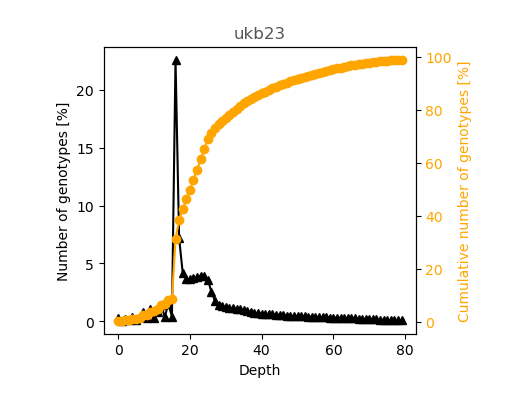

>>> ~/output/vcf_stats/depth.0.png:

bash: /home/dmc2245/output/vcf_stats/depth.0.png: Permission denied



In [10]:
%preview -s png  ~/output/vcf_stats/depth.0.png

> /home/dmc2245/output/vcf_stats/dp_by_sample.0.png (21.0 KiB):

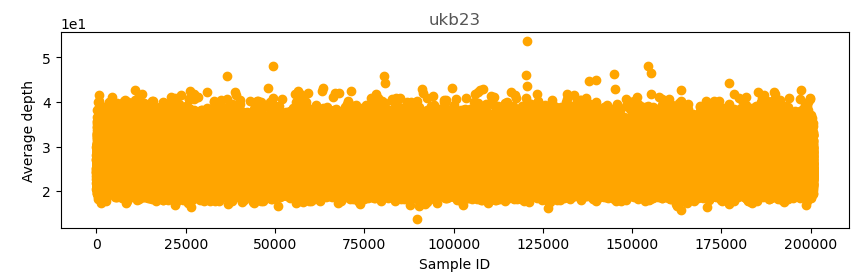

>>> ~/output/vcf_stats/dp_by_sample.0.png:

bash: /home/dmc2245/output/vcf_stats/dp_by_sample.0.png: Permission denied



In [11]:
%preview -s png  ~/output/vcf_stats/dp_by_sample.0.png

> /home/dmc2245/output/vcf_stats/hets_by_sample.0.png (28.0 KiB):

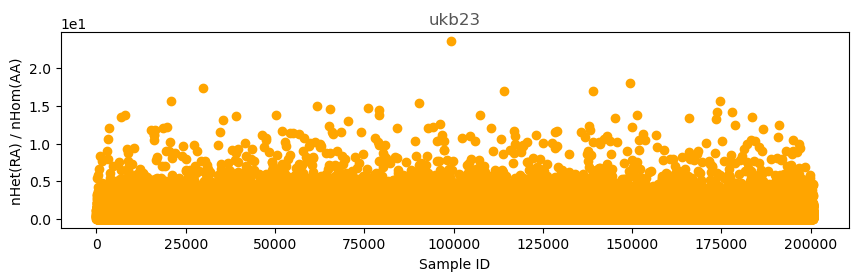

>>> ~/output/vcf_stats/hets_by_sample.0.png:

bash: /home/dmc2245/output/vcf_stats/hets_by_sample.0.png: Permission denied



In [12]:
%preview -s png  ~/output/vcf_stats/hets_by_sample.0.png

> /home/dmc2245/output/vcf_stats/hwe.0.png (32.5 KiB):

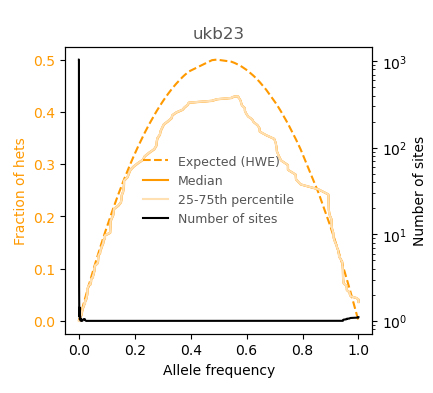

>>> ~/output/vcf_stats/hwe.0.png:

bash: /home/dmc2245/output/vcf_stats/hwe.0.png: Permission denied



In [13]:
%preview -s png  ~/output/vcf_stats/hwe.0.png

> /home/dmc2245/output/vcf_stats/indel_vaf.0.png (30.0 KiB):

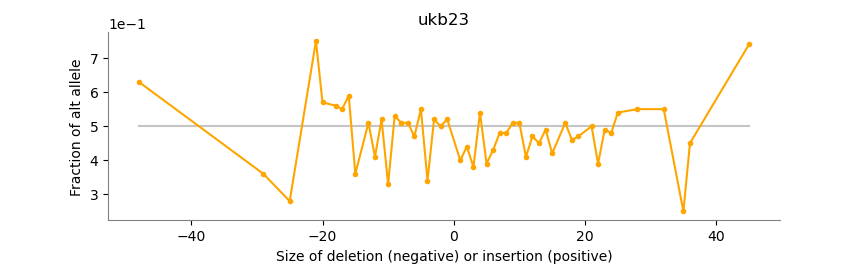

>>> ~/output/vcf_stats/indel_vaf.0.png:

bash: /home/dmc2245/output/vcf_stats/indel_vaf.0.png: Permission denied



In [14]:
%preview -s png  ~/output/vcf_stats/indel_vaf.0.png

> /home/dmc2245/output/vcf_stats/indels.0.png (11.8 KiB):

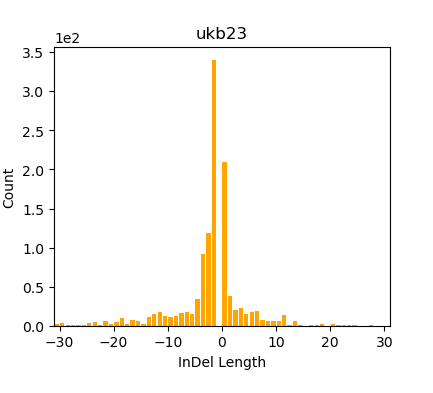

>>> ~/output/vcf_stats/indels.0.png:

bash: /home/dmc2245/output/vcf_stats/indels.0.png: Permission denied



In [15]:
%preview -s png  ~/output/vcf_stats/indels.0.png

> /home/dmc2245/output/vcf_stats/indels_by_sample.0.png (30.0 KiB):

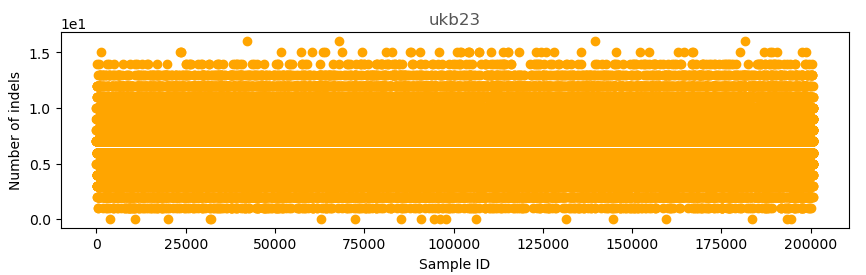

>>> ~/output/vcf_stats/indels_by_sample.0.png:

bash: /home/dmc2245/output/vcf_stats/indels_by_sample.0.png: Permission denied



In [16]:
%preview -s png  ~/output/vcf_stats/indels_by_sample.0.png

> /home/dmc2245/output/vcf_stats/singletons_by_sample.0.png (17.9 KiB):

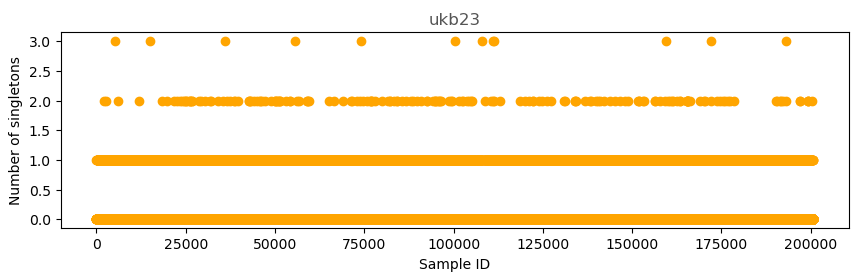

>>> ~/output/vcf_stats/singletons_by_sample.0.png:

bash: /home/dmc2245/output/vcf_stats/singletons_by_sample.0.png: Permission denied



In [17]:
%preview -s png  ~/output/vcf_stats/singletons_by_sample.0.png

> /home/dmc2245/output/vcf_stats/snps_by_sample.0.png (25.9 KiB):

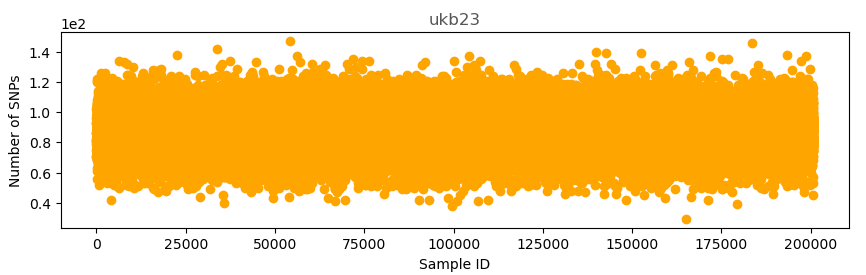

>>> ~/output/vcf_stats/snps_by_sample.0.png:

bash: /home/dmc2245/output/vcf_stats/snps_by_sample.0.png: Permission denied



In [18]:
%preview -s png  ~/output/vcf_stats/snps_by_sample.0.png

> /home/dmc2245/output/vcf_stats/substitutions.0.png (12.3 KiB):

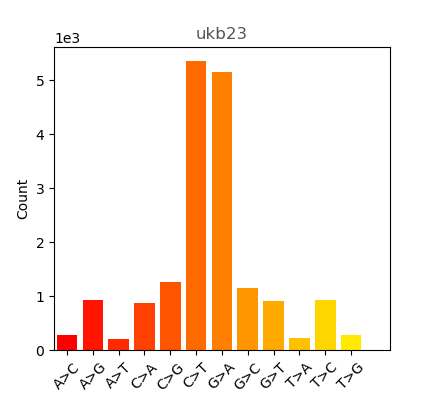

>>> ~/output/vcf_stats/substitutions.0.png:

bash: /home/dmc2245/output/vcf_stats/substitutions.0.png: Permission denied



In [19]:
%preview -s png  ~/output/vcf_stats/substitutions.0.png

> /home/dmc2245/output/vcf_stats/tstv_by_qual.0.png (18.4 KiB):

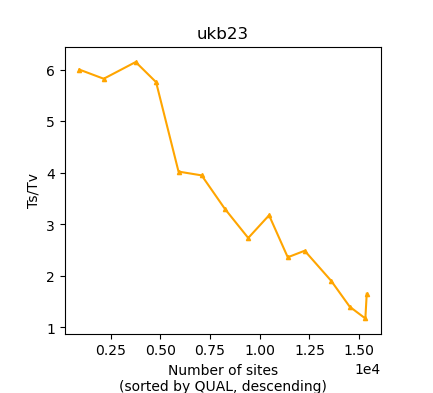

>>> ~/output/vcf_stats/tstv_by_qual.0.png:

bash: /home/dmc2245/output/vcf_stats/tstv_by_qual.0.png: Permission denied



In [20]:
%preview -s png  ~/output/vcf_stats/tstv_by_qual.0.png

> /home/dmc2245/output/vcf_stats/tstv_by_sample.0.png (25.9 KiB):

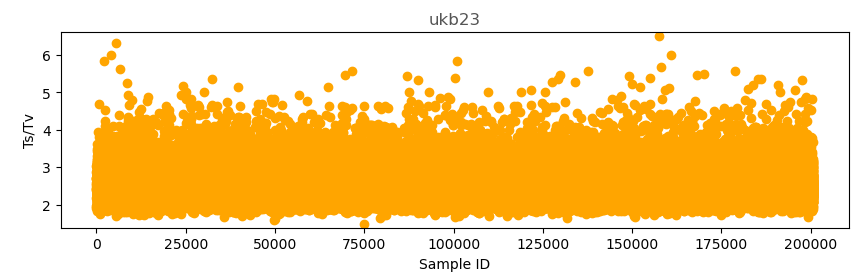

>>> ~/output/vcf_stats/tstv_by_sample.0.png:

bash: /home/dmc2245/output/vcf_stats/tstv_by_sample.0.png: Permission denied



In [21]:
%preview -s png  ~/output/vcf_stats/tstv_by_sample.0.png

In [2]:
#Take a look at the FORMAT/GQ, FORMAT/DP and AB measures

$bcf query $vcf_file -f '[%GQ]\t[%DP]\n' > ~/output/vcf_stats/chr1.GQ.DP.txt

In [1]:
$bcf stats --af-bins 0.1,0.5,1 -d 0,500,1 $vcf_file >  ~/output/vcf_stats/ukbb_chr1_b1.vchk

In [ ]:
$bcf AVG(GQ)>50 

In [ ]:
$bcf query -i 'GT = "alt" & GT = "hom"' -f "%CHROM\t%POS\n[\t%SAMPLE\t%GT\t%GQ\n]" $vcf_file

Restarting kernel "Bash"


In [ ]:
$bcf query -f "%CHROM\t%POS\t%ID\t%INFO/AF\t%QUAL\t%INFO/BaseQRankSum" $vcf_file

In [1]:
$bcf query -e'FILTER="."' -f'%CHROM %POS %FILTER\n' $vcf_file | head -2

chr1 925849 MONOALLELIC
chr1 930388 MONOALLELIC
[main_vcfquery] Error: close failed .. (null)



In [20]:
$bcf view -i 'GT="het" && (AB >0.20)' $vcf_file | head -2

[filter.c:2914 filters_init1] Error: the tag "AB" is not defined in the VCF header



In [18]:
$bcf query -i'FMT/DP>10 & FMT/GQ>20' -f'%CHROM\tPOS\t%QUAL\t[%SAMPLE:DP=%DP GQ=%GQ]\n' $vcf_file | head -2

chr1	POS	40	5671571:DP=11 GQ=332402342:DP=11 GQ=335969821:DP=11 GQ=334706202:DP=11 GQ=331693285:DP=12 GQ=361284567:DP=11 GQ=334777909:DP=12 GQ=362247310:DP=11 GQ=335263860:DP=12 GQ=365218702:DP=12 GQ=362114153:DP=12 GQ=365833399:DP=12 GQ=36
chr1	POS	36	1213363:DP=11 GQ=334348256:DP=11 GQ=335090129:DP=12 GQ=364271819:DP=12 GQ=363336708:DP=12 GQ=365872349:DP=11 GQ=333352244:DP=11 GQ=331357191:DP=11 GQ=334543113:DP=11 GQ=333519740:DP=11 GQ=333575639:DP=12 GQ=365714872:DP=11 GQ=333813942:DP=11 GQ=333556915:DP=11 GQ=335874663:DP=11 GQ=333991743:DP=12 GQ=362602823:DP=12 GQ=362553296:DP=11 GQ=335671571:DP=16 GQ=484287252:DP=13 GQ=395192179:DP=11 GQ=333823333:DP=11 GQ=331462342:DP=11 GQ=333323897:DP=12 GQ=361751570:DP=12 GQ=361460074:DP=12 GQ=362777172:DP=11 GQ=335563962:DP=12 GQ=361437023:DP=11 GQ=331810519:DP=14 GQ=424771160:DP=12 GQ=362552168:DP=11 GQ=332788594:DP=12 GQ=361234424:DP=16 GQ=483924315:DP=11 GQ=333391406:DP=11 GQ=335902725:DP=12 GQ=361446616:DP=12 GQ=365243530:DP=11 GQ=33464111

In [21]:
$bcf query -i 'TYPE="snp" && MIN(DP)>5 && QUAL>10' -f'%CHROM\tPOS\t%QUAL\t[%SAMPLE:DP=%DP GQ=%GQ]\n' $vcf_file | head -2

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Plot VCF stats

In [ ]:
~/software/bin/./plot-vcfstats --merge chr{1..22} > ~/output/vcf_stats/merged_stats.vchk

In [ ]:
~/software/bin/./plot-vcfstats \
    --prefix ~/output/vcf_stats/merged_plots \
    --main-title 'Summary statistics plots for UKBB pVCF'\
    ~/output/vcf_stats/merged_stats.vchk

### Filter VCF files

1. Genotype depth filters: SNPs DP>=7 and Indels DP>=10 for indels
    > Then only SNV variant sites that met at least one of the following two criteria were [retained](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjPw5r_s5fvAhUVUzUKHe7GD-kQFjAEegQIDRAD&url=https%3A%2F%2Fwww.biorxiv.org%2Fcontent%2Fbiorxiv%2Fearly%2F2019%2F03%2F09%2F572347%2FDC2%2Fembed%2Fmedia-2.pdf%3Fdownload%3Dtrue&usg=AOvVaw06fvt4jBTPq5VfepojT1mZ) according to filtering made on the ~50K exomes by the UKBB
    
    > 1) at least one heterozygous variant genotype with allele balance ratio greater than or equal to 15% (AB >= 0.15) 
    
    > 2) at least one homozygous variant genotype
    
2. At least one variant genotype passing the Allele Balance filter: heterozygous SNV AB>=0.15, heterozygous indel>=0.20
3. Genotype quality GQ>=20

In [2]:
#the DP value in the INFO is the sum of the DP value over all samples in your vcf at this position. The DP value in the FORMAT column in the read depth for the given sample at this position. If you just have one sample this value should be equal.
#FORMAT/DP
#FORMAT/GQ

bcftools view  -i  'MIN(FMT/DP)>10 & MIN(FMT/GQ)>15'   my.vcf.gz

bcftools filter -i 'TYPE="snp" && MIN(DP)>5 && QUAL>10' input.vcf > output.vcf

[E::hts_open_format] Failed to open file "my.vcf.gz" : No such file or directory
Failed to read from my.vcf.gz: No such file or directory
[E::hts_open_format] Failed to open file "input.vcf" : No such file or directory
Failed to read from input.vcf: No such file or directory



In [ ]:
# Filter SNPs